# Transfer between Hermitian operators in the absence of relaxation

## Final density matrix is the commutator of the hamiltonian and the initial density matrix

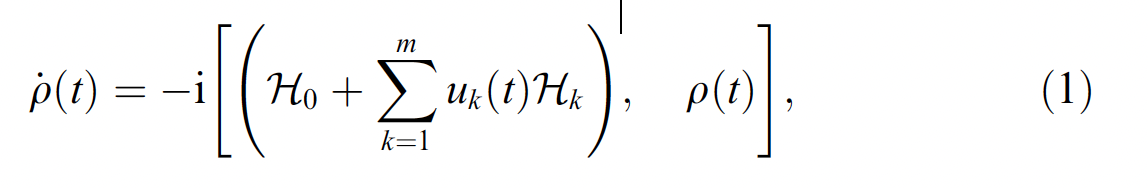

## CNOT Example

In [33]:
import qutip as qt

In [34]:
from utils.gates import cnot
import jax.numpy as jnp
from utils.operators import identity, sigmax, sigmay, sigmaz
from utils.tensor import tensor
from grape import optimize_pulse, fidelity, sesolve

In [49]:
rho_target = cnot() @ cnot().conj().T
rho_initial = identity(4) @ identity(4).conj().T
H_drift = 0 * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()))
H_ctrl = [
    tensor(sigmax(), identity(2)),
    tensor(sigmay(), identity(2)),
    tensor(sigmaz(), identity(2)),
    tensor(identity(2), sigmax()),
    tensor(identity(2), sigmay()),
    tensor(identity(2), sigmaz()),
    tensor(sigmax(), sigmax()),
    tensor(sigmay(), sigmay()),
    tensor(sigmaz(), sigmaz()),
]
num_t_slots = 500
total_evo_time = 2 * jnp.pi
res = optimize_pulse(
    H_drift,
    H_ctrl,
    rho_initial,
    rho_target,
    num_t_slots,
    total_evo_time,
    max_iter=100,
    learning_rate=1e-2,
    optimizer="adam",
    type="density",
)
print("final_fidelity: ", res.final_fidelity)
print("U_f \n", res.final_operator)
print("Converged after: ", res.iterations)

final_fidelity:  1.0
U_f 
 [[ 1.00000000e+00+1.21430643e-17j -1.70253622e-18+3.03576608e-18j
  -4.91746672e-16-4.33680869e-17j -4.22838847e-18-2.51534904e-17j]
 [ 4.00138364e-18-4.33680869e-18j  1.00000000e+00-7.80625564e-18j
  -1.82145965e-17-2.14672030e-16j -9.48723488e-17+4.05491613e-17j]
 [-4.97613222e-16+3.79470760e-17j -1.86584418e-17+2.19442520e-16j
   1.00000000e+00+3.46944695e-18j -1.16201062e-16-3.47378376e-16j]
 [-3.17806762e-18+5.37764278e-17j -1.05916176e-16-3.62123526e-17j
  -1.08847122e-16+3.37837397e-16j  1.00000000e+00+1.12757026e-17j]]
Converged after:  2


In [50]:
qt.fidelity(
    qt.Qobj(res.final_operator / jnp.trace(res.final_operator)),
    qt.Qobj(rho_target / jnp.trace(rho_target)),
)  # should be close to 1

np.float64(0.9999999999999998)

In [51]:
# Reconstucting hamiltonian
def build_ham_reconstructed(control_amplitudes):
    """
    Build Hamiltonian for given (complex) e_qub and e_cav
    """

    H_ctrl = (
        control_amplitudes[0] * tensor(sigmax(), identity(2))
        + control_amplitudes[1] * tensor(sigmay(), identity(2))
        + control_amplitudes[2] * tensor(sigmaz(), identity(2))
        + control_amplitudes[3] * tensor(identity(2), sigmax())
        + control_amplitudes[4] * tensor(identity(2), sigmay())
        + control_amplitudes[5] * tensor(identity(2), sigmaz())
        + control_amplitudes[6] * tensor(sigmax(), sigmax())
        + control_amplitudes[7] * tensor(sigmay(), sigmay())
        + control_amplitudes[8] * tensor(sigmaz(), sigmaz())
    )

    H_drift = 0 * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()))

    H = H_drift + H_ctrl
    return H

In [52]:
# Construct the Hamiltonian for each time slot
H_total = jnp.array(
    [
        build_ham_reconstructed(res.control_amplitudes[i, :])
        for i in range(num_t_slots)
    ]
)

# Initial state
psi0_fg = identity(4) @ identity(4).conj().T

# Time intervals
delta_ts = jnp.repeat(total_evo_time / num_t_slots, num_t_slots).astype(
    jnp.float32
)

# Solve the Schrödinger equation
psi_fg = sesolve(H_total, psi0_fg, delta_ts)

# Target state
rho_target = cnot() @ cnot().conj().T

# Calculate fidelity
print(fidelity(C_target=rho_target, U_final=psi_fg, type="density"))

1.0023642934163868


## Time Dependent with density Matrices

In [39]:
## MAIN.py with time_dep example

import jax
import jax.numpy as jnp
from grape import (
    optimize_pulse,
    plot_control_amplitudes,
    sesolve,
    fidelity,
)
from utils.operators import identity, destroy, sigmap, sigmaz
from utils.tensor import tensor
from utils.states import basis
# ruff: noqa

N_cav = 10
chi = 0.2385 * (2 * jnp.pi)
mu_qub = 4.0
mu_cav = 8.0
hconj = lambda a: jnp.swapaxes(a.conj(), -1, -2)
time_start = 0.0
time_end = 1.0
time_intervals_num = 5
N_cav = 10
# Eqivalant to delta_ts = jnp.repeat(0.2, time_intervals_num).astype(jnp.float32)
# However, it is implemented in this way to be more general and
# show that these are the differences between the time intervals
t_grid = jnp.linspace(time_start, time_end, time_intervals_num + 1)
delta_ts = t_grid[1:] - t_grid[:-1]
fake_random_key = jax.random.key(seed=0)
e_data = jax.random.uniform(
    fake_random_key, shape=(4, len(delta_ts)), minval=-1, maxval=1
)
e_qub = e_data[0] + 1j * e_data[1]
e_cav = e_data[2] + 1j * e_data[3]


@jax.vmap
def build_ham(e_qub, e_cav):
    """
    Build Hamiltonian for given (complex) e_qub and e_cav
    """

    a = tensor(identity(2), destroy(N_cav))
    adag = hconj(a)
    n_phot = adag @ a
    sigz = tensor(sigmaz(), identity(N_cav))
    sigp = tensor(sigmap(), identity(N_cav))
    one = tensor(identity(2), identity(N_cav))

    H0 = +(chi / 2) * n_phot @ (sigz + one)

    H_ctrl = mu_qub * sigp * e_qub + mu_cav * adag * e_cav
    H_ctrl += hconj(H_ctrl)
    # You just pass an array of the Hamiltonian matrices "Hs" corresponding to the time
    # intervals "delta_ts" (that is, "Hs" is a 3D array).
    return H0, H_ctrl


H0, H_ctrl = build_ham(e_qub, e_cav)


# Representation for time dependent Hamiltonian
def solve(Hs, delta_ts):
    """
    Find evolution operator for piecewise Hs on time intervals delts_ts
    """
    for i, (H, delta_t) in enumerate(zip(Hs, delta_ts)):
        U_intv = jax.scipy.linalg.expm(-1j * H * delta_t)
        U = U_intv if i == 0 else U_intv @ U
    return U


U = solve(H0 + H_ctrl, delta_ts)
psi0 = tensor(basis(2), basis(N_cav)) @ tensor(basis(2), basis(N_cav)).conj().T
global psi_target_qt
psi_target_qt = psi_target = (U @ psi0) @ (U @ psi0).conj().T


def build_grape_format_ham():
    """
    Build Hamiltonian for given (complex) e_qub and e_cav
    """

    a = tensor(identity(2), destroy(N_cav))
    adag = hconj(a)
    n_phot = adag @ a
    sigz = tensor(sigmaz(), identity(N_cav))
    sigp = tensor(sigmap(), identity(N_cav))
    one = tensor(identity(2), identity(N_cav))

    H0 = +(chi / 2) * n_phot @ (sigz + one)
    H_ctrl_qub = mu_qub * sigp
    H_ctrl_qub_dag = hconj(H_ctrl_qub)
    H_ctrl_cav = mu_cav * adag
    H_ctrl_cav_dag = hconj(H_ctrl_cav)

    H_ctrl = [H_ctrl_qub, H_ctrl_qub_dag, H_ctrl_cav, H_ctrl_cav_dag]

    return H0, H_ctrl


def test_time_dep(optimizer="adam"):
    H0_grape, H_ctrl_grape = build_grape_format_ham()

    res = optimize_pulse(
        H0_grape,
        H_ctrl_grape,
        psi0,
        psi_target,
        int(
            (time_end - time_start) / delta_ts[0]
        ),  # Ensure this is an integer
        time_end - time_start,
        max_iter=10000,
        # when you decrease convergence threshold, it is more accurate
        convergence_threshold=1e-3,
        learning_rate=1e-2,
        type="density",
        optimizer=optimizer,
    )
    return res

In [40]:
res = test_time_dep("l-bfgs")
print("final_fidelity: ", res.final_fidelity)

final_fidelity:  0.9988626218285693


In [41]:
### Define the time grid (same as defined)
time_start = 0.0
time_end = 1.0
time_intervals_num = 5
N_cav = 10
# Eqivalant to delta_ts = jnp.repeat(0.2, time_intervals_num).astype(jnp.float32)
# However, it is implemented in this way to be more general and
# show that these are the differences between the time intervals
t_grid = jnp.linspace(time_start, time_end, time_intervals_num + 1)
delta_ts = t_grid[1:] - t_grid[:-1]


### Build the Hamiltonian
def build_ham_reconstructed(u1, u2, u3, u4):
    """
    Build Hamiltonian for given (complex) e_qub and e_cav
    """

    a = tensor(identity(2), destroy(N_cav))
    adag = hconj(a)
    n_phot = adag @ a
    sigz = tensor(sigmaz(), identity(N_cav))
    sigp = tensor(sigmap(), identity(N_cav))
    one = tensor(identity(2), identity(N_cav))

    H0 = +(chi / 2) * n_phot @ (sigz + one)
    H_ctrl_qub = mu_qub * sigp
    H_ctrl_qub_dag = hconj(H_ctrl_qub)
    H_ctrl_cav = mu_cav * adag
    H_ctrl_cav_dag = hconj(H_ctrl_cav)

    # Apply control amplitudes
    H_ctrl = (
        u1 * H_ctrl_qub
        + u2 * H_ctrl_qub_dag
        + u3 * H_ctrl_cav
        + u4 * H_ctrl_cav_dag
    )

    H = H0 + H_ctrl
    return H


u1 = res.control_amplitudes[:, 0]
u2 = res.control_amplitudes[:, 1]
u3 = res.control_amplitudes[:, 2]
u4 = res.control_amplitudes[:, 3]
u1
### Construct the Hamiltonian for each time step
H_total = jnp.array(
    [
        build_ham_reconstructed(u1[i], u2[i], u3[i], u4[i])
        for i in range(len(u1))
    ]
)
H_total
H_total.shape
### Solve the Schrödinger Equation

psi0_fg = (
    tensor(basis(2), basis(N_cav)) @ tensor(basis(2), basis(N_cav)).conj().T
)
psi_fg = (
    sesolve(H_total, psi0_fg, delta_ts)
    @ sesolve(H_total, psi0_fg, delta_ts).conj().T
)
### Calculate fidelity with target
print(fidelity(C_target=psi_target, U_final=psi_fg, type="density"))

0.9988626195947395


## Dissapative using density matrix dynamics

In [42]:
import jax.numpy as jnp
from grape import *
from utils.gates import *
from utils.operators import *
from utils.states import *
from utils.superoperator import *
from utils.tensor import *

In [43]:
Sx = sigmax()
Sy = sigmay()
Sz = sigmaz()
Sm = sigmam()
Si = identity(2)
had_gate = hadamard()
# Hamiltonian
Del = 0.1  # Tunnelling term
wq = 1.0  # Energy of the 2-level system.
H0 = 0.5 * wq * sigmaz() + 0.5 * Del * sigmax()

# Amplitude damping#
# Damping rate:
gamma = 0.1
L0 = liouvillian(H0, [jnp.sqrt(gamma) * Sm])

# sigma X control
LC_x = liouvillian(Sx)
# sigma Y control
LC_y = liouvillian(Sy)
# sigma Z control
LC_z = liouvillian(Sz)

# Drift
drift = L0
# Controls - different combinations can be tried
ctrls = [LC_z, LC_x]
# Number of ctrls
n_ctrls = len(ctrls)

# start point for the map evolution
E0 = sprepost(Si, Si)

# target for map evolution
E_targ = sprepost(had_gate, had_gate)

# Number of time slots
n_ts = 10
# Time allowed for the evolution
evo_time = 2

# here using the superoperator dynamics lead to extremely high fidelity
result = optimize_pulse(
    drift,
    ctrls,
    E0,
    E_targ,
    n_ts,
    evo_time,
    type="superoperator",
    optimizer="l-bfgs",
    convergence_threshold=1e-16,
    max_iter=100000,
    learning_rate=0.35,
)

In [44]:
result.final_fidelity

Array(0.94786882, dtype=float64)

In [45]:
result.final_operator

Array([[ 5.57533513e-02-1.75980267e-01j,  2.95344419e+02+9.51248935e+01j,
         5.04941221e-05+1.30005952e-05j,  9.72949958e-01+1.30860140e-01j],
       [-5.00462208e-05-6.59537983e-05j,  2.96469937e-02-4.26664595e-02j,
        -1.83276982e-07-4.46286272e-08j,  6.37081855e-05-3.16347208e-05j],
       [-2.15773210e+02-3.49907797e+02j, -4.97354500e+06-1.19938675e+06j,
         2.55589853e-02-4.40457607e-02j,  2.93271538e+02-1.54877311e+02j],
       [ 9.44246649e-01+1.75980267e-01j, -2.95344419e+02-9.51248935e+01j,
        -5.04941221e-05-1.30005952e-05j,  2.70500422e-02-1.30860140e-01j]],      dtype=complex128)

In [46]:
fidelity_qt = qt.tracedist(
    qt.Qobj(E_targ).unit(), qt.Qobj(result.final_operator).unit()
)  # should be close to 1

In [47]:
print("final_fidelity_qt: ", fidelity_qt)

final_fidelity_qt:  0.9096768164798428


## Using desnity matrix dynamics

In [48]:
import jax.numpy as jnp
from grape import *
from utils.gates import *
from utils.operators import *
from utils.states import *
from utils.superoperator import *
from utils.tensor import *
import qutip as qt

Sx = sigmax()
Sy = sigmay()
Sz = sigmaz()
Sm = sigmam()
Si = identity(2)
had_gate = hadamard()
# Hamiltonian
Del = 0.1  # Tunnelling term
wq = 1.0  # Energy of the 2-level system.
H0 = 0.5 * wq * sigmaz() + 0.5 * Del * sigmax()

# Amplitude damping#
# Damping rate:
gamma = 0.1
L0 = liouvillian(H0, [jnp.sqrt(gamma) * Sm])

# sigma X control
LC_x = liouvillian(Sx)
# sigma Y control
LC_y = liouvillian(Sy)
# sigma Z control
LC_z = liouvillian(Sz)

# Drift
drift = L0
# Controls - different combinations can be tried
ctrls = [LC_z, LC_x]
# Number of ctrls
n_ctrls = len(ctrls)

# start point for the map evolution
E0 = sprepost(Si, Si) @ sprepost(Si, Si).conj().T

# target for map evolution
E_targ = sprepost(had_gate, had_gate) @ sprepost(had_gate, had_gate).conj().T

# Number of time slots
n_ts = 10
# Time allowed for the evolution
evo_time = 2

# here using the superoperator dynamics lead to extremely high fidelity but actually
# does not match with qutip's fidelity ± meaning that 2.0 is probably some error
result = optimize_pulse(
    drift,
    ctrls,
    E0,
    E_targ,
    n_ts,
    evo_time,
    type="density",
    optimizer="l-bfgs",
    convergence_threshold=1e-16,
    max_iter=100000,
    learning_rate=0.35,
)
print(result.final_fidelity)
print(result.final_operator)
fidelity_qt = qt.fidelity(
    qt.Qobj(E_targ).unit(), qt.Qobj(result.final_operator).unit()
)  # should be close to 1
print("final_fidelity_qt: ", fidelity_qt)

0.9904154326059835
[[ 1.00000000e+00+0.00000000e+00j  2.21218707e-16-1.86341314e-15j
   9.41949200e-17+3.07428868e-16j -7.89390060e-02+3.89418342e-01j]
 [ 2.21218707e-16+1.86341314e-15j  1.00000000e+00+0.00000000e+00j
   3.67774590e-31-6.54625741e-29j -7.50480541e-16+7.47517457e-16j]
 [ 9.41949200e-17-3.07428868e-16j  3.67774590e-31+6.54625741e-29j
   1.00000000e+00+3.46944695e-18j -1.95760340e-16+8.08466816e-16j]
 [-7.89390060e-02-3.89418342e-01j -7.50480541e-16-7.47517457e-16j
  -1.95760340e-16-8.08466816e-16j  1.15787801e+00-8.67361738e-19j]]
final_fidelity_qt:  0.9904154326059835
